# Text Sentiment Classification using RNNs

Tweets data from [HuggingFace](https://huggingface.co/datasets/dair-ai/emotion)

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
data_path = os.getcwd() + "/drive/MyDrive/CS4/merged_training.pkl"

Mounted at /content/drive


In [2]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
%matplotlib inline

In [3]:
data = pd.read_pickle(data_path)

In [5]:
data.head(10)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


# Preprocessing

In [64]:
# Get value counts for each emotion in the dataset
data.emotions.value_counts()

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64

In [65]:
# Drop "love" and "surprise" entries
data = data[~data["emotions"].isin(["love", "surprise"])]
data.emotions.value_counts()

joy        141067
sadness    121187
anger       57317
fear        47712
Name: emotions, dtype: int64

# EDA

Build **word clouds** for each emotion
- Word clouds are very intuitive and a great and fast way to get a first impression on what a piece of text is talking about.

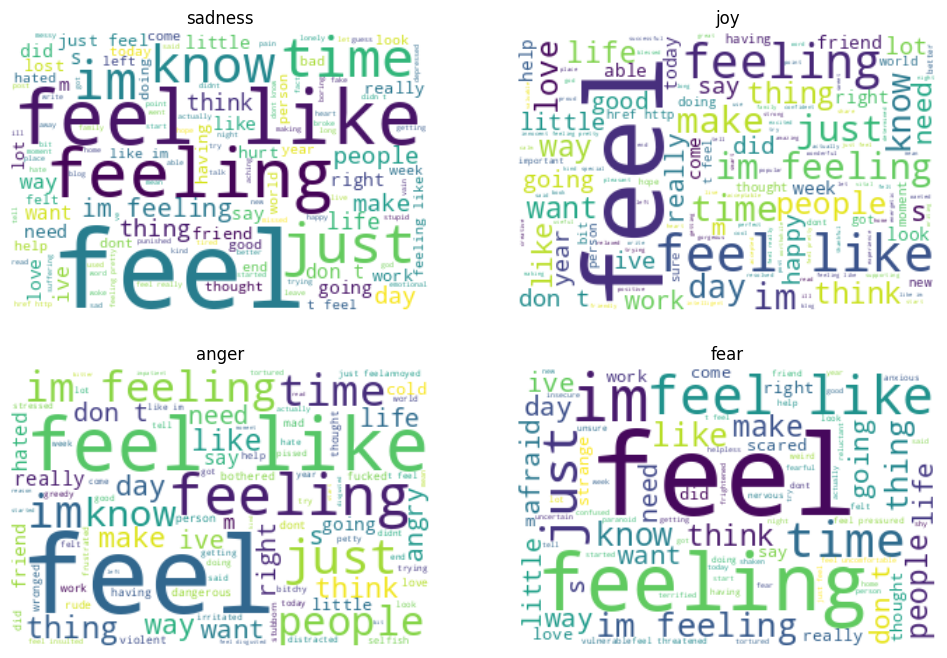

In [66]:
emotions = data.emotions.unique()

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, emotion in enumerate(emotions):
    filtered_data = data[data["emotions"] == emotion]
    text = " ".join(filtered_data["text"])
    wordcloud = WordCloud(
        background_color='white', width=300, height=200, stopwords=ENGLISH_STOP_WORDS
    ).generate(text)
    axes[i // 2, i % 2].imshow(wordcloud, interpolation="bilinear")
    axes[i // 2, i % 2].set_title(emotion, fontsize=12)
    axes[i // 2, i % 2].axis("off")

In [67]:
from sklearn.model_selection import train_test_split

X = data.drop("emotions", axis="columns")
y = data["emotions"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

# Combine X_train and y_train
train = pd.concat([X_train, y_train], axis=1)

# Combine X_test and y_test
test = pd.concat([X_test, y_test], axis=1)

# Tokenizing

Only pay attention to the 1000 most common words. Less common words get a label "\<UNK>", which stands for "unknown".

In [68]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000, oov_token='<UNK>')
tokenizer.fit_on_texts(train.text)

In [87]:
# Save fitted tokenizer for later use
import pickle
with open("tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

# Padding and Truncating Sequences

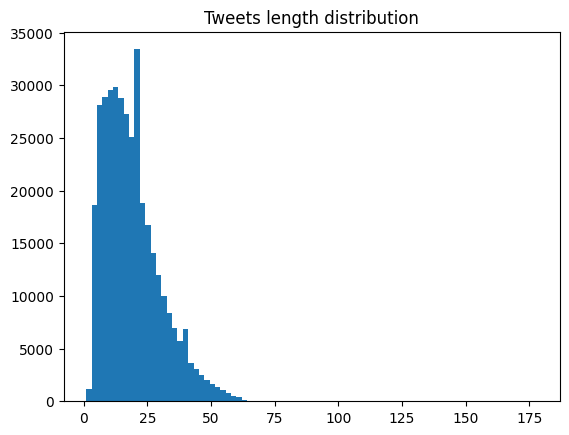

In [69]:
# Check the lengths of the tweets
lengths = [len(tweet.split(' ')) for tweet in data.text]
plt.hist(lengths, bins=len(set(lengths)))
plt.title("Tweets length distribution")
plt.show()

 Here we turn the tweets into lists of numbers using the tokenizer, and then make sure all the lists have the same length (50 words) by either shortening longer ones from the end or adding zeros to shorter ones at the end.

 This is to prepare the data for models that expect input sequences of the same length.

In [70]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 50

# define function for creating padded sequences
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [71]:
# Create padded sequence for training
padded_train_seq = get_sequences(tokenizer, train.text)
padded_train_seq[0]

array([  2,  96, 115, 113, 111,   1, 124, 753,   5,   6,   1,  26, 115,
        30,   6,   1,  33,   2,   1,  28,  13, 137,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Convert labels to indexes

In [72]:
# Convert classes to index
classes = set(data.emotions)
print(classes)

{'fear', 'sadness', 'anger', 'joy'}


In [73]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [74]:
class_to_index

{'fear': 0, 'sadness': 1, 'anger': 2, 'joy': 3}

In [75]:
index_to_class

{0: 'fear', 1: 'sadness', 2: 'anger', 3: 'joy'}

In [76]:
# function for converting the categorical labels of the dataset to index
emotions_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [77]:
# convert train labels to index
train_labels = emotions_to_ids(train.emotions)

# Model training

The neural network consists of:

- **Embedding layer**: creates an n-dimensional word embedding of an input text
- **Bidirectional LSTM layers**: combine outputs from both directions to get a richer understanding
- **Dense output layer**: softmax activation function applied to make predictions over 4 possible emotion classes

In [78]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(1000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [79]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [80]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_6 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 4)                 164       
                                                                 
Total params: 31844 (124.39 KB)
Trainable params: 31844 (124.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
# Create padded sequence for testing
test_seq = get_sequences(tokenizer, test.text)
test_labels = emotions_to_ids(test.emotions)

In [82]:
test.text.iloc[0], test_labels[0]

('i was concerned about a friend s feelings and i didn t know what actions on my part would be most considerate',
 3)

In [83]:
# Train on GPU
with tf.device('/device:GPU:0'):
    history = model.fit(
        padded_train_seq,
        train_labels,
        validation_data=(test_seq, test_labels),
        epochs=5,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        ]
    )

Epoch 1/5
9183/9183 [==============================] - 169s 18ms/step - loss: 0.2686 - accuracy: 0.8909 - val_loss: 0.1676 - val_accuracy: 0.9287
Epoch 2/5
   9/9183 [..............................] - ETA: 2:02 - loss: 0.1993 - accuracy: 0.9236

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9183/9183 [==============================] - 147s 16ms/step - loss: 0.1600 - accuracy: 0.9303 - val_loss: 0.1552 - val_accuracy: 0.9316
Epoch 3/5
9183/9183 [==============================] - 159s 17ms/step - loss: 0.1490 - accuracy: 0.9333 - val_loss: 0.1519 - val_accuracy: 0.9303
Epoch 4/5
9183/9183 [==============================] - 138s 15ms/step - loss: 0.1428 - accuracy: 0.9353 - val_loss: 0.1467 - val_accuracy: 0.9325
Epoch 5/5
9183/9183 [==============================] - 140s 15ms/step - loss: 0.1387 - accuracy: 0.9365 - val_loss: 0.1459 - val_accuracy: 0.9338


In [84]:
# Create function for plotting learning curves
def plot_history_metrics(history):
    """
    Plot the accuracy and loss for the training and validation data
    """
    fig = plt.figure(figsize=(15,8))

    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'b', label = 'acc')
    plt.plot(history.history['val_accuracy'], 'r', label = 'val_acc')
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'], 'b', label = 'loss')
    plt.plot(history.history['val_loss'], 'r', label = 'val_loss')
    plt.title("Train Loss vs Validation Loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

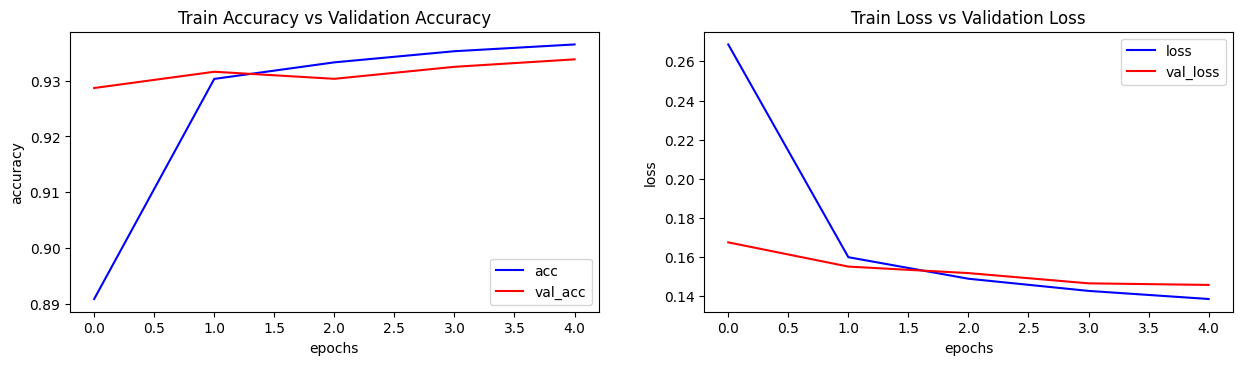

In [85]:
plot_history_metrics(history)

In [86]:
# Save trained model
model.save('model.h5')

# Evaluation

In [41]:
# Load the saved model
saved_model = tf.keras.models.load_model("model.h5")

# Use the loaded model for prediction, evaluation, etc.
predictions = saved_model.predict(test_seq)

2296/2296 [==============================] - 38s 16ms/step


In [45]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
predicted_labels = tf.argmax(predictions, axis=1).numpy()
print(classification_report(test_labels, predicted_labels, target_names=classes))

              precision    recall  f1-score   support

        fear       0.90      0.90      0.90      9542
     sadness       0.93      0.95      0.94     24238
       anger       0.92      0.83      0.87     11463
         joy       0.95      0.97      0.96     28214

    accuracy                           0.93     73457
   macro avg       0.93      0.91      0.92     73457
weighted avg       0.93      0.93      0.93     73457



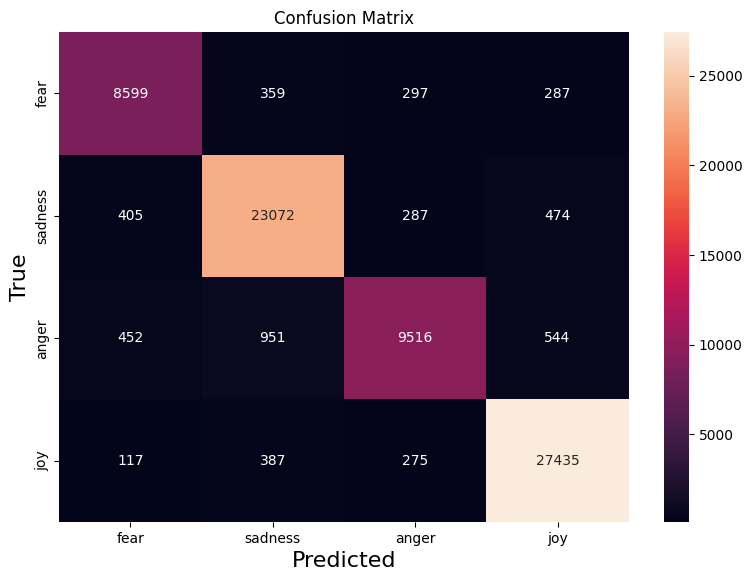

In [48]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize = (9,7))
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, fmt='d')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.title('Confusion Matrix')
plt.tight_layout(pad=5.0)